Datasets used: 
- `Law School Success` :<br>
The dataset was originally collected for a study called 'LSAC National Longitudinal Bar Passage Study'. It includes background information and if (and how) candidates passed the bar exam to become lawyers/legal practicioners in the USA<br>

    Important Variables:
    
    gender: Gender of the student.<br>
    lsat: LSAT score received by the student.<br>
    pass_bar: Ground truth label indicating whether or not the student eventually passed the bar.<br>
    race: Race of the student.<br>
    gpa: A student's undergraduate GPA.<br>

Reference Links: https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage?resource=download

In [2]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [3]:
sensitive_attribute = "gender"

## Load Dataset

In [4]:
DATAFILE= "bar_pass_prediction.csv"

learning_class_weights = {0: 50, 1: 5}

X = pd.read_csv(DATAFILE)
#Drop unnecessary features
X = X.drop(columns=['sex','dnn_bar_pass_prediction','ID','bar_passed','race',
                    'race2','decile1b','decile3','decile1','zfygpa','asian','black','hisp','other','index6040','bar1','bar2','DOB_yr','male','bar','indxgrp','indxgrp2','grad'
                    ,'bar1_yr','bar2_yr','parttime','age','cluster'])
num_features = X._get_numeric_data().columns.to_list()

df = X.copy()
cate_features = df.select_dtypes(include=['object']).columns.to_list()
df = df.dropna()
df = df.reset_index(drop=True)

df.head()

,lsat,ugpa,zgpa,fulltime,fam_inc,gender,race1,Dropout,pass_bar,tier,gpa
0,44.0,3.5,1.88,1.0,5.0,female,white,NO,1,4.0,3.5
1,29.0,3.5,-0.57,1.0,4.0,female,white,NO,1,2.0,3.5
2,36.0,3.5,-1.12,1.0,1.0,male,white,NO,1,3.0,3.5
3,39.0,3.5,-0.49,1.0,4.0,male,white,NO,1,3.0,3.5
4,48.0,3.5,0.76,1.0,4.0,male,white,NO,1,5.0,3.5


## Model training and test

In [5]:
X = df.drop('pass_bar', axis=1)
y = df['pass_bar']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [6]:
%%time

model = customLogisticRegression(max_iter = 1500,class_weight = learning_class_weights)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='labels')
model.predict(X_test.iloc[:100, :])

CPU times: total: 109 ms
Wall time: 153 ms


array([0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
       1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.])

In [7]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.21      0.65      0.32       315
           1       0.98      0.87      0.92      5900

    accuracy                           0.86      6215
   macro avg       0.60      0.76      0.62      6215
weighted avg       0.94      0.86      0.89      6215



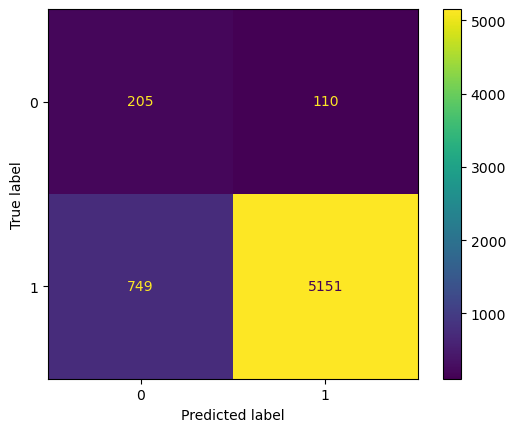

In [8]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [11]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='gender',
    freqitem_minsupp = 0.01,
    missing_subgroup_val="Unknown",
    drop_infeasible = False,
    drop_above = False
 )

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.67it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 135.98it/s]


2385 2385
Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|█████████████████████████████████████████████████████████████████████████████| 2385/2385 [00:09<00:00, 254.85it/s]

Computing correctenesses for all valid if-thens.



100%|███████████████████████████████████████████████████████████████████████████| 52698/52698 [06:16<00:00, 139.82it/s]


Number of if-thens: 52698


In [9]:
#### Uncomment if you wish to load rules object from disk

import dill

with open("rulesLawSchool.data", "rb") as inf:
    rules_by_if = dill.load(inf)

FileNotFoundError: [Errno 2] No such file or directory: 'rulesLawSchool.data'

In [10]:
#### Uncomment if you wish to save rules object on disk

import dill

with open("rulesLawSchool.data", "wb") as outf:
     dill.dump(rules_by_if, outf)

In [12]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["male"][1][0][1]-e[1]["female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If fulltime = 2.0, gpa = 2.8, ugpa = 2.8:
	Protected Subgroup 'female', 1.21% covered
		Make fulltime = 1.0, gpa = 3.5, ugpa = 3.5 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.4, ugpa = 3.4 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.3, ugpa = 3.3 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.6, ugpa = 3.6 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.2, ugpa = 3.2 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.1, ugpa = 3.1 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.0, ugpa = 3.0 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.7, ugpa = 3.7 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 2.9, ugpa = 2.9 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.8, ugpa = 3.8 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.9, ugpa = 3.9 with correctness 0.00%.
		Make fulltime = 1.0 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 2.7, ugpa = 2.7 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 2.6, ugpa =

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [13]:
feature_weights = {"gender": 1, "race1": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [14]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If Dropout = NO, fulltime = 2.0, gpa = 2.8:
	Protected Subgroup 'female', 1.21% covered out of 9064
		Make fulltime = 1.0, gpa = 3.5 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.4 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.3 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.6 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.2 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.1 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.0 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.7 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 2.9 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.8 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 3.9 with correctness 0.00%.
		Make fulltime = 1.0 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 2.7 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 2.6 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 2.5 with correctness 0.00%.
		Make fulltime = 1.0, gpa = 2.4 with correctness 0.00%.

## Minimum cost above threshold

In [15]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
    secondary_sorting=True
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If Dropout = NO, fulltime = 2.0, race1 = white:
	Protected Subgroup 'female', 7.89% covered out of 9064
		Make fulltime = 1.0 with correctness 51.28%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'male', 9.13% covered out of 11652
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Bias against male. Unfairness measure = inf.
If fulltime = 2.0, race1 = white:
	Protected Subgroup 'female', 7.89% covered out of 9064
		Make fulltime = 1.0 with correctness 51.28%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'male', 9.13% covered out of 11652
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Bias against male. Unfairness measure = inf.
If Dropout = NO, fam_inc = 3.0, fulltime = 2.0, race1 = white:
	Protected Subgroup 'female', 5.06% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'male', 2.61% covered out of 11652
		

In [15]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
    secondary_sorting=True
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If fulltime = 2.0:
	Subgroup 'female', 16.09% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 17.44% covered out of 11652
		Make fulltime = 1.0 with correctness 58.89%.
		Aggregate cost of the above recourses = 1.00
	Bias against female. Unfairness measure = inf.
If Dropout = NO, fulltime = 2.0:
	Subgroup 'female', 16.09% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 17.44% covered out of 11652
		Make fulltime = 1.0 with correctness 58.89%.
		Aggregate cost of the above recourses = 1.00
	Bias against female. Unfairness measure = inf.
If fam_inc = 4.0, tier = 4.0:
	Subgroup 'female', 5.91% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 7.17% covered out of 11652
		Make tier = 6.0 with correctness 51.35%.
		Make fam_inc = 5.0, tier = 6.0 with correctness 51.35%.
		Aggregate cost

## Mean cost above threshold

In [16]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If Dropout = NO, fam_inc = 3.0, tier = 4.0:
	Protected Subgroup 'female', 9.11% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'male', 7.83% covered out of 11652
		Make fam_inc = 4.0, tier = 6.0 with correctness 50.00%.
		Aggregate cost of the above recourses = 2.00
	Bias against female. Unfairness measure = inf.
If fam_inc = 3.0, tier = 4.0:
	Protected Subgroup 'female', 9.11% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'male', 7.83% covered out of 11652
		Make fam_inc = 4.0, tier = 6.0 with correctness 50.00%.
		Aggregate cost of the above recourses = 2.00
	Bias against female. Unfairness measure = inf.
If Dropout = NO, fulltime = 2.0, race1 = white:
	Protected Subgroup 'female', 7.89% covered out of 9064
		Make fulltime = 1.0 with correctness 51.28%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'male', 9.13% covere

In [16]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If fulltime = 2.0:
	Subgroup 'female', 16.09% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 17.44% covered out of 11652
		Make fulltime = 1.0 with correctness 58.89%.
		Aggregate cost of the above recourses = 1.00
	Bias against female. Unfairness measure = inf.
If Dropout = NO, fulltime = 2.0:
	Subgroup 'female', 16.09% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 17.44% covered out of 11652
		Make fulltime = 1.0 with correctness 58.89%.
		Aggregate cost of the above recourses = 1.00
	Bias against female. Unfairness measure = inf.
If Dropout = NO, fam_inc = 3.0, tier = 4.0:
	Subgroup 'female', 9.78% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 6.01% covered out of 11652
		Make fam_inc = 4.0, tier = 6.0 with correctness 58.06%.
		Make fam_inc = 5.0, tier = 6.0 with correct

## Number above threshold

In [17]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If Dropout = NO, fam_inc = 3.0, lsat = 33.0, race1 = white:
	Protected Subgroup 'female', 1.42% covered out of 9064
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'male', 1.96% covered out of 11652
		Make fam_inc = 4.0, lsat = 40.0 with correctness 88.89%.
		Make fam_inc = 4.0, lsat = 39.0 with correctness 77.78%.
		Make fam_inc = 4.0, lsat = 37.0 with correctness 66.67%.
		Make fam_inc = 4.0, lsat = 38.0 with correctness 66.67%.
		Make lsat = 37.0 with correctness 66.67%.
		Make fam_inc = 4.0, lsat = 36.0 with correctness 66.67%.
		Make fam_inc = 4.0, lsat = 35.0 with correctness 66.67%.
		Make fam_inc = 4.0, lsat = 42.0 with correctness 100.00%.
		Make fam_inc = 4.0, lsat = 41.0 with correctness 100.00%.
		Make lsat = 40.0 with correctness 77.78%.
		Make lsat = 39.0 with correctness 66.67%.
		Make lsat = 36.0 with correctness 55.56%.
		Make lsat = 38.0 with correctness 66.67%.
		Make lsat = 41.0 with correctness 88.89%.
		Make lsa

In [17]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If gpa = 2.8, race1 = white, tier = 2.0:
	Subgroup 'female', 1.02% covered out of 9064
		Make gpa = 3.7, tier = 6.0 with correctness 60.00%.
		Aggregate cost of the above recourses = -1.00
	Subgroup 'male', 1.36% covered out of 11652
		Make gpa = 3.2, tier = 3.0 with correctness 57.14%.
		Make gpa = 3.0, tier = 3.0 with correctness 57.14%.
		Make gpa = 3.4, tier = 4.0 with correctness 71.43%.
		Make gpa = 3.3, tier = 3.0 with correctness 57.14%.
		Make gpa = 3.4, tier = 3.0 with correctness 57.14%.
		Make gpa = 3.1, tier = 3.0 with correctness 57.14%.
		Make gpa = 3.3, tier = 4.0 with correctness 71.43%.
		Make gpa = 3.5, tier = 3.0 with correctness 57.14%.
		Make gpa = 3.5, tier = 4.0 with correctness 71.43%.
		Make gpa = 2.9, tier = 3.0 with correctness 57.14%.
		Make gpa = 3.6, tier = 4.0 with correctness 71.43%.
		Make gpa = 3.2, tier = 4.0 with correctness 71.43%.
		Make gpa = 3.7, tier = 4.0 with correctness 71.43%.
		Make gpa = 3.1, tier = 4.0 with correctness 71.43%.
		Make tie

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [20]:
import dill

with open("stateLawSchool.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

If Dropout = NO, fam_inc = 3.0, race1 = other:
	Subgroup 'female', 1.22% covered out of 9064
		Make fam_inc = 4.0, race1 = white with correctness 16.67%.
		Make race1 = white with correctness 0.00%.
		Make fam_inc = 5.0, race1 = white with correctness 16.67%.
		Make fam_inc = 2.0, race1 = white with correctness 0.00%.
		Make fam_inc = 4.0, race1 = asian with correctness 0.00%.
		Make race1 = asian with correctness 0.00%.
		Make race1 = hisp with correctness 0.00%.
		Make race1 = black with correctness 0.00%.
	Subgroup 'male', 1.55% covered out of 11652
		Make fam_inc = 4.0, race1 = white with correctness 50.00%.
		Make race1 = white with correctness 50.00%.
		Make fam_inc = 5.0, race1 = white with correctness 50.00%.
		Make fam_inc = 2.0, race1 = white with correctness 50.00%.
		Make fam_inc = 4.0, race1 = asian with correctness 50.00%.
		Make race1 = asian with correctness 37.50%.
		Make race1 = hisp with correctness 12.50%.
		Make race1 = black with correctness 25.00%.
	Bias against 

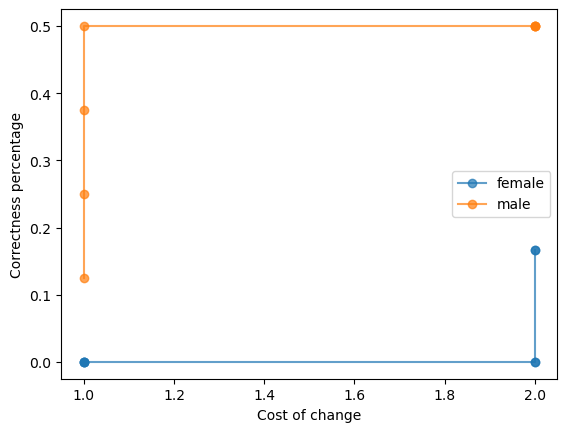

If fam_inc = 3.0, race1 = other:
	Subgroup 'female', 1.22% covered out of 9064
		Make fam_inc = 4.0, race1 = white with correctness 16.67%.
		Make race1 = white with correctness 0.00%.
		Make fam_inc = 5.0, race1 = white with correctness 16.67%.
		Make fam_inc = 2.0, race1 = white with correctness 0.00%.
		Make fam_inc = 4.0, race1 = asian with correctness 0.00%.
		Make race1 = asian with correctness 0.00%.
		Make race1 = hisp with correctness 0.00%.
		Make race1 = black with correctness 0.00%.
	Subgroup 'male', 1.55% covered out of 11652
		Make fam_inc = 4.0, race1 = white with correctness 50.00%.
		Make race1 = white with correctness 50.00%.
		Make fam_inc = 5.0, race1 = white with correctness 50.00%.
		Make fam_inc = 2.0, race1 = white with correctness 50.00%.
		Make fam_inc = 4.0, race1 = asian with correctness 50.00%.
		Make race1 = asian with correctness 37.50%.
		Make race1 = hisp with correctness 12.50%.
		Make race1 = black with correctness 25.00%.
	Bias against female. Unfair

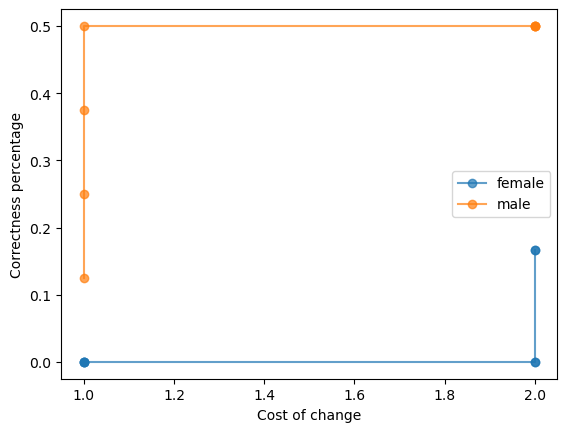

If Dropout = NO, fulltime = 1.0, lsat = 36.0, race1 = white:
	Subgroup 'female', 2.04% covered out of 9064
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 39.0 with correctness 20.00%.
		Make lsat = 40.0 with correctness 20.00%.
		Make lsat = 42.0 with correctness 30.00%.
		Make lsat = 41.0 with correctness 20.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 10.00%.
		Make lsat = 34.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 30.00%.
		Make lsat = 33.0 with correctness 0.00%.
		Make lsat = 44.0 with correctness 30.00%.
		Make lsat = 32.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 40.00%.
		Make lsat = 46.0 with correctness 40.00%.
		Make lsat = 31.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 60.00%.
		Make lsat = 47.0 with correctness 60.00%.
		Make lsat = 30.0 with correctness 0.00%.
	Subgroup 'male', 3.10% covered out of 11652
		Make lsat = 37.0 with correctness 12.50%.
		Make lsat = 39.0 

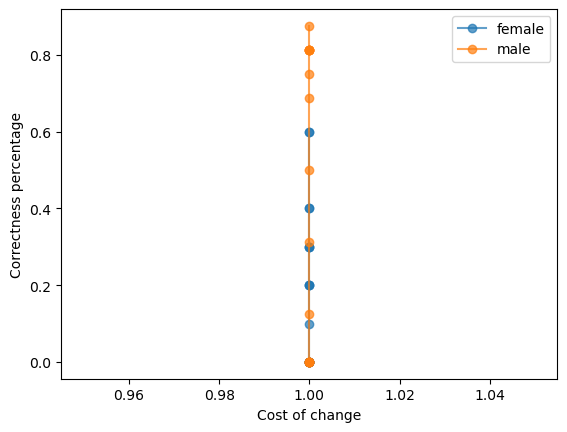

If fulltime = 1.0, lsat = 36.0, race1 = white:
	Subgroup 'female', 2.04% covered out of 9064
		Make lsat = 37.0 with correctness 0.00%.
		Make lsat = 39.0 with correctness 20.00%.
		Make lsat = 40.0 with correctness 20.00%.
		Make lsat = 42.0 with correctness 30.00%.
		Make lsat = 41.0 with correctness 20.00%.
		Make lsat = 35.0 with correctness 0.00%.
		Make lsat = 38.0 with correctness 10.00%.
		Make lsat = 34.0 with correctness 0.00%.
		Make lsat = 33.0 with correctness 0.00%.
		Make lsat = 43.0 with correctness 30.00%.
		Make lsat = 44.0 with correctness 30.00%.
		Make lsat = 32.0 with correctness 0.00%.
		Make lsat = 45.0 with correctness 40.00%.
		Make lsat = 46.0 with correctness 40.00%.
		Make lsat = 31.0 with correctness 0.00%.
		Make lsat = 48.0 with correctness 60.00%.
		Make lsat = 47.0 with correctness 60.00%.
		Make lsat = 30.0 with correctness 0.00%.
	Subgroup 'male', 3.10% covered out of 11652
		Make lsat = 37.0 with correctness 12.50%.
		Make lsat = 39.0 with correctne

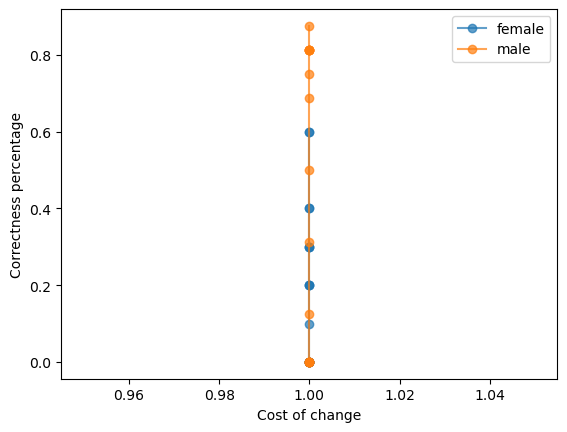

If gpa = 2.8, race1 = white, tier = 2.0:
	Subgroup 'female', 1.02% covered out of 9064
		Make gpa = 3.2, tier = 3.0 with correctness 20.00%.
		Make gpa = 3.0, tier = 3.0 with correctness 0.00%.
		Make gpa = 3.4, tier = 4.0 with correctness 20.00%.
		Make gpa = 3.3, tier = 3.0 with correctness 20.00%.
		Make gpa = 3.4, tier = 3.0 with correctness 20.00%.
		Make gpa = 3.1, tier = 3.0 with correctness 20.00%.
		Make gpa = 3.3, tier = 4.0 with correctness 20.00%.
		Make gpa = 3.5, tier = 3.0 with correctness 20.00%.
		Make gpa = 3.5, tier = 4.0 with correctness 20.00%.
		Make gpa = 2.9, tier = 3.0 with correctness 0.00%.
		Make gpa = 3.6, tier = 4.0 with correctness 20.00%.
		Make gpa = 3.2, tier = 4.0 with correctness 20.00%.
		Make gpa = 3.7, tier = 4.0 with correctness 20.00%.
		Make gpa = 3.1, tier = 4.0 with correctness 20.00%.
		Make tier = 3.0 with correctness 0.00%.
		Make gpa = 3.7, tier = 5.0 with correctness 40.00%.
		Make gpa = 3.8, tier = 4.0 with correctness 20.00%.
		Make gp

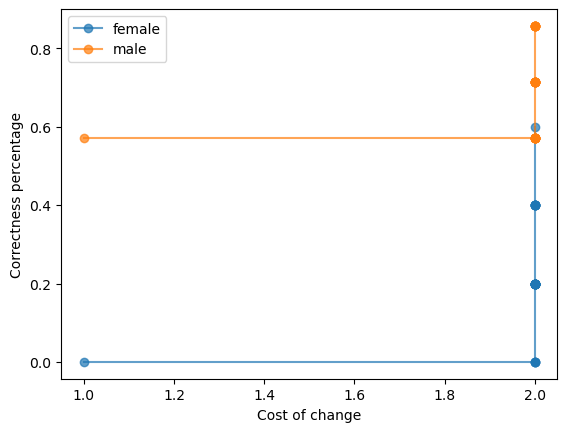

If Dropout = NO, gpa = 2.8, race1 = white, tier = 2.0:
	Subgroup 'female', 1.02% covered out of 9064
		Make gpa = 3.2, tier = 3.0 with correctness 20.00%.
		Make gpa = 3.0, tier = 3.0 with correctness 0.00%.
		Make gpa = 3.4, tier = 4.0 with correctness 20.00%.
		Make gpa = 3.3, tier = 3.0 with correctness 20.00%.
		Make gpa = 3.4, tier = 3.0 with correctness 20.00%.
		Make gpa = 3.1, tier = 3.0 with correctness 20.00%.
		Make gpa = 3.3, tier = 4.0 with correctness 20.00%.
		Make gpa = 3.5, tier = 3.0 with correctness 20.00%.
		Make gpa = 3.5, tier = 4.0 with correctness 20.00%.
		Make gpa = 2.9, tier = 3.0 with correctness 0.00%.
		Make gpa = 3.6, tier = 4.0 with correctness 20.00%.
		Make gpa = 3.2, tier = 4.0 with correctness 20.00%.
		Make gpa = 3.7, tier = 4.0 with correctness 20.00%.
		Make gpa = 3.1, tier = 4.0 with correctness 20.00%.
		Make tier = 3.0 with correctness 0.00%.
		Make gpa = 3.7, tier = 5.0 with correctness 40.00%.
		Make gpa = 3.8, tier = 4.0 with correctness 20.

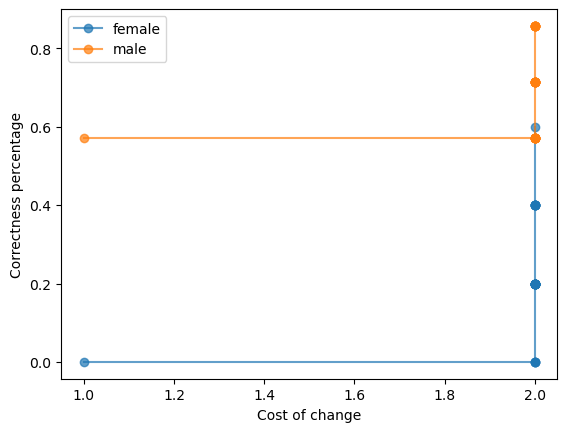

If race1 = white, tier = 2.0, ugpa = 2.8:
	Subgroup 'female', 1.02% covered out of 9064
		Make tier = 3.0, ugpa = 3.2 with correctness 20.00%.
		Make tier = 3.0, ugpa = 3.0 with correctness 0.00%.
		Make tier = 4.0, ugpa = 3.4 with correctness 20.00%.
		Make tier = 3.0, ugpa = 3.3 with correctness 20.00%.
		Make tier = 3.0, ugpa = 3.4 with correctness 20.00%.
		Make tier = 3.0, ugpa = 3.1 with correctness 20.00%.
		Make tier = 4.0, ugpa = 3.3 with correctness 20.00%.
		Make tier = 3.0, ugpa = 3.5 with correctness 20.00%.
		Make tier = 4.0, ugpa = 3.5 with correctness 20.00%.
		Make tier = 3.0, ugpa = 2.9 with correctness 0.00%.
		Make tier = 4.0, ugpa = 3.6 with correctness 20.00%.
		Make tier = 4.0, ugpa = 3.2 with correctness 20.00%.
		Make tier = 4.0, ugpa = 3.7 with correctness 20.00%.
		Make tier = 4.0, ugpa = 3.1 with correctness 20.00%.
		Make tier = 3.0 with correctness 0.00%.
		Make tier = 5.0, ugpa = 3.7 with correctness 40.00%.
		Make tier = 4.0, ugpa = 3.8 with correctness 

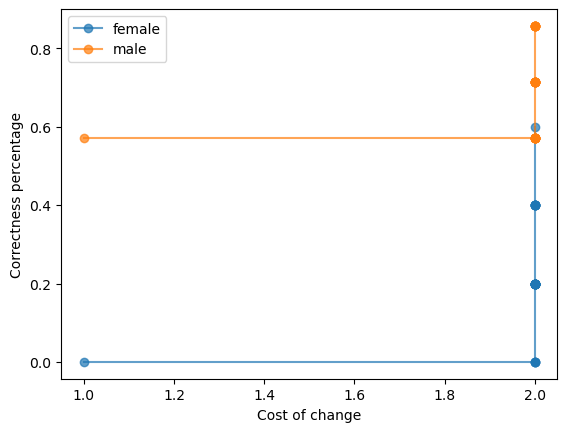

If Dropout = NO, race1 = white, tier = 2.0, ugpa = 2.8:
	Subgroup 'female', 1.02% covered out of 9064
		Make tier = 3.0, ugpa = 3.2 with correctness 20.00%.
		Make tier = 3.0, ugpa = 3.0 with correctness 0.00%.
		Make tier = 4.0, ugpa = 3.4 with correctness 20.00%.
		Make tier = 3.0, ugpa = 3.3 with correctness 20.00%.
		Make tier = 3.0, ugpa = 3.4 with correctness 20.00%.
		Make tier = 3.0, ugpa = 3.1 with correctness 20.00%.
		Make tier = 4.0, ugpa = 3.3 with correctness 20.00%.
		Make tier = 3.0, ugpa = 3.5 with correctness 20.00%.
		Make tier = 4.0, ugpa = 3.5 with correctness 20.00%.
		Make tier = 3.0, ugpa = 2.9 with correctness 0.00%.
		Make tier = 4.0, ugpa = 3.6 with correctness 20.00%.
		Make tier = 4.0, ugpa = 3.2 with correctness 20.00%.
		Make tier = 4.0, ugpa = 3.7 with correctness 20.00%.
		Make tier = 4.0, ugpa = 3.1 with correctness 20.00%.
		Make tier = 3.0 with correctness 0.00%.
		Make tier = 5.0, ugpa = 3.7 with correctness 40.00%.
		Make tier = 4.0, ugpa = 3.8 wit

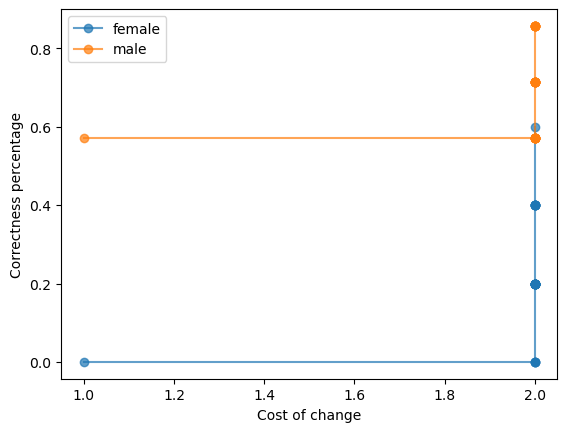

If race1 = hisp, tier = 1.0:
	Subgroup 'female', 1.22% covered out of 9064
		Make race1 = white, tier = 3.0 with correctness 100.00%.
		Make race1 = white, tier = 4.0 with correctness 100.00%.
		Make race1 = white, tier = 5.0 with correctness 100.00%.
		Make race1 = white, tier = 6.0 with correctness 100.00%.
		Make race1 = white, tier = 2.0 with correctness 66.67%.
		Make race1 = asian, tier = 5.0 with correctness 100.00%.
	Subgroup 'male', 1.16% covered out of 11652
		Make race1 = white, tier = 3.0 with correctness 33.33%.
		Make race1 = white, tier = 4.0 with correctness 50.00%.
		Make race1 = white, tier = 5.0 with correctness 66.67%.
		Make race1 = white, tier = 6.0 with correctness 66.67%.
		Make race1 = white, tier = 2.0 with correctness 16.67%.
		Make race1 = asian, tier = 5.0 with correctness 50.00%.
	Bias against male. Unfairness measure = 0.24.
	Cumulative correctness plot for the above recourses:


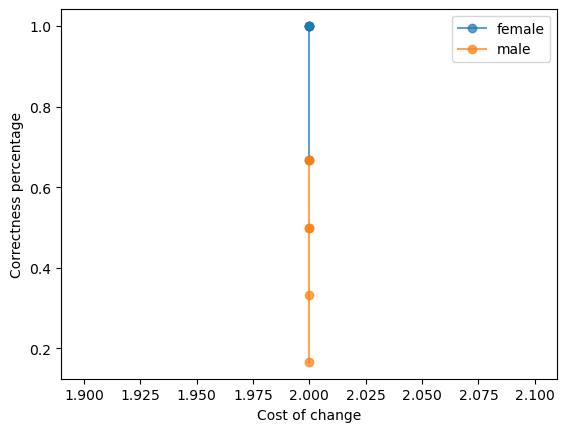

If Dropout = NO, race1 = hisp, tier = 1.0:
	Subgroup 'female', 1.22% covered out of 9064
		Make race1 = white, tier = 3.0 with correctness 100.00%.
		Make race1 = white, tier = 4.0 with correctness 100.00%.
		Make race1 = white, tier = 5.0 with correctness 100.00%.
		Make race1 = white, tier = 6.0 with correctness 100.00%.
		Make race1 = white, tier = 2.0 with correctness 66.67%.
		Make race1 = asian, tier = 5.0 with correctness 100.00%.
	Subgroup 'male', 1.16% covered out of 11652
		Make race1 = white, tier = 3.0 with correctness 33.33%.
		Make race1 = white, tier = 4.0 with correctness 50.00%.
		Make race1 = white, tier = 5.0 with correctness 66.67%.
		Make race1 = white, tier = 6.0 with correctness 66.67%.
		Make race1 = white, tier = 2.0 with correctness 16.67%.
		Make race1 = asian, tier = 5.0 with correctness 50.00%.
	Bias against male. Unfairness measure = 0.24.
	Cumulative correctness plot for the above recourses:


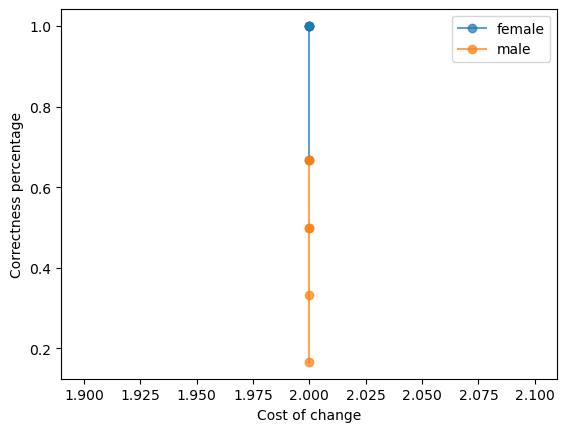

In [21]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="weighted-average",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute=sensitive_attribute)

pop_sizes = {sg: (df[sensitive_attribute] == sg).sum() for sg in df[sensitive_attribute].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [19]:
import dill

with open("stateLawSchool.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)